This is the solution example for the exercises given in [PredictWeight.ipynb](PredictWeight.ipynb)

# First exercise: Data normalization using StandardScaler

Data loading works similarly as before:

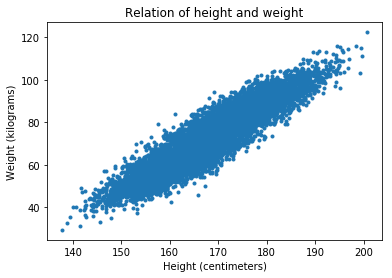

In [3]:
import numpy as np
import matplotlib.pyplot as pp
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1" #disable Tensorflow GPU usage, a simple example like this runs faster on CPU
import tensorflow as tf
from tensorflow import keras  


data=np.loadtxt("../Datasets/weight-height.csv",skiprows=1,usecols=(1,2),delimiter=",")
data[:,0]*=2.54
data[:,1]*=0.45359237
pp.scatter(data[:,0],data[:,1],marker=".")
pp.title("Relation of height and weight")
pp.xlabel("Height (centimeters)")
pp.ylabel("Weight (kilograms)")
pp.show()

Now, to optimize the data for neural networks, we make it zero-mean, unit standard deviation using the StandardScaler

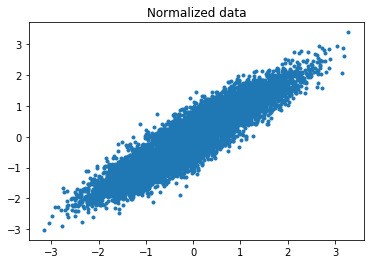

In [5]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler.fit(data)
scaled=scaler.transform(data)
pp.scatter(scaled[:,0],scaled[:,1],marker=".")
pp.title("Normalized data")
pp.show()

With this data, training the neural network will be much faster. We will first train a single-neuron network, i.e., a simple linear model. You should see that the model is pretty good already after 5 epochs, even though we use a smaller learning rate of 0.01, which allows the model to fit more accurately.

Epoch 1/5
10000/10000 [==============================] - 0s 37us/step - loss: 0.1573
Epoch 2/5
10000/10000 [==============================] - 0s 44us/step - loss: 0.1454

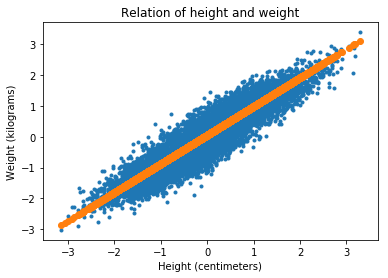

In [7]:
#keras.Sequential makes it easy to compose a neural network models out of layers
model = keras.Sequential()

#Add a 1-neuron layer with linear activation, taking one input value. 
#The input_shape=(1,) defines that there's only a single input value, but batch size is yet unknown.
#Note that this notation is a bit misleading, as the batch data index dimension is really the first one and not the second one.  
#Fortunately, the input_shape needs to only be specified for the first layer
model.add(keras.layers.Dense(1,input_shape=(1,)))

#Make the model ready for optimization using Adam optimizer (the usual reasonable first guess).
#The loss parameter defines the loss function that optimization tries to minimize, in this case
#the mean squared error between the network outputs and actual data values.
#The lr parameter is the "learning rate". With this simple model, we can use a high learning rate of 0.1,
#whereas many complex networks require 0.001 or even 0.0001. This makes training more stable but also more slow.
model.compile(optimizer=keras.optimizers.Adam(lr=0.01),loss="mean_squared_error")

#Define our training inputs and outputs. Our network takes in height (column 0 in the data) and outputs weight (column 1).
trainingInputs=scaled[:,0]
trainingOutputs=scaled[:,1]

#Reshape the tensors: This is needed because Tensorflow and Keras models expect to get data in batches, as specified above.
trainingInputs=np.reshape(trainingInputs,[trainingInputs.shape[0],1])
trainingOutputs=np.reshape(trainingOutputs,[trainingOutputs.shape[0],1])

#Fit (train) the model. Epochs defines how many times the network will see all data during the training.
model.fit(trainingInputs,trainingOutputs,verbose=1,epochs=5)

#Plot the data and predictions given by the network
pp.scatter(trainingInputs[:,0],trainingOutputs[:,0],marker=".")
pp.title("Relation of height and weight")
pp.xlabel("Height (centimeters)")
pp.ylabel("Weight (kilograms)")
predictions=model.predict(trainingInputs)
#NOTE: The predictions is of the same shape as trainingOutputs, i.e., [10000,1]
#scatter() expects 1-dimensional x and y arrays; thus, we need to use the [:,0] and [:,1] indexing.
pp.scatter(trainingInputs[:,0],predictions[:,0])
pp.show()

Note that when using this model for predicting real, non-scaled values, we must use the scaler. There's afew ways to go about it. If you want to stick to the transform() and inverse_transform() functions, it can be a bit cumbersome, as one needs to always think of what kind of tensor shapes are fed in to networks and functions and what shapes are received as output:

In [19]:
#We want to predict height from this weight:
weight=200
#To get normalized weight, we must compose a [1,2] shaped tensor for the scaler, i.e., 
#1 pair of weights and heights. Weight is the first value and the second value can be anything (we use 0).
normalizedWeight=scaler.transform([[weight,0]])
#The scaler returns a tensor of similar shape, let's get the actual weight value out of it
normalizedWeight=normalizedWeight[0,0]
#Now, to get a normalized height, we can feed this to the network.
#Again, the returned value is a batch, so we take the first element
normalizedHeight=model.predict([[normalizedWeight]])[0,0]
#Finally, we can use the scaler to get unnormalized 
height=scaler.inverse_transform([[normalizedWeight,normalizedHeight]])
#The scaler returns a tensor of similar shape, let's get the actual height value out of it
height=height[0,1]
print("The predicted weight for a person who weighs",weight,"kg is ",height)

The predicted weight for a person who weighs 200 kg is  117.60076135436134


If you feel more comfortable doing the calculations yourself, you can directly access the scaler's mean and variance. The standard deviation equals the square root of the variance.

In [22]:
normalizedWeight=(200-scaler.mean_[0])/np.sqrt(scaler.var_[0])
normalizedHeight=normalizedHeight=model.predict([[normalizedWeight]])[0,0]
height=normalizedHeight*np.sqrt(scaler.var_[1])+scaler.mean_[1]
print("The predicted weight for a person who weighs 200kg is ",height)

The predicted weight for a person who weighs 200kg is  117.60076135436134


# Second exercise: use a more complex neural network. 

To see things in more detail and get to demonstrate overfitting, we will only use the first 50 data points. Overfitting can be mitigated by using a larger dataset, a more simple model, or a regularization technique such as dropout.

Here, overfitting should manifest as a nonlinear model, even though the data is from a (noisy) linear relation.

To gain a better feel of overfitting, you can try different data, layer, and neuron counts 

Epoch 1/100
 - 1s - loss: 1.0733
Epoch 2/100
 - 0s - loss: 1.0089
Epoch 3/100
 - 0s - loss: 0.9573
Epoch 4/100
 - 0s - loss: 0.9264
Epoch 5/100
 - 0s - loss: 0.8983
Epoch 6/100
 - 0s - loss: 0.8719
Epoch 7/100
 - 0s - loss: 0.8465
Epoch 8/100
 - 0s - loss: 0.8201
Epoch 9/100
 - 0s - loss: 0.7984
Epoch 10/100
 - 0s - loss: 0.7722
Epoch 11/100
 - 0s - loss: 0.7502
Epoch 12/100
 - 0s - loss: 0.7292
Epoch 13/100
 - 0s - loss: 0.7089
Epoch 14/100
 - 0s - loss: 0.6880
Epoch 15/100
 - 0s - loss: 0.6685
Epoch 16/100
 - 0s - loss: 0.6508
Epoch 17/100
 - 0s - loss: 0.6318
Epoch 18/100
 - 0s - loss: 0.6161
Epoch 19/100
 - 0s - loss: 0.5989
Epoch 20/100
 - 0s - loss: 0.5825
Epoch 21/100
 - 0s - loss: 0.5680
Epoch 22/100
 - 0s - loss: 0.5521
Epoch 23/100
 - 0s - loss: 0.5382
Epoch 24/100
 - 0s - loss: 0.5226
Epoch 25/100
 - 0s - loss: 0.5104
Epoch 26/100
 - 0s - loss: 0.4964
Epoch 27/100
 - 0s - loss: 0.4837
Epoch 28/100
 - 0s - loss: 0.4717
Epoch 29/100
 - 0s - loss: 0.4594
Epoch 30/100
 - 0s - lo

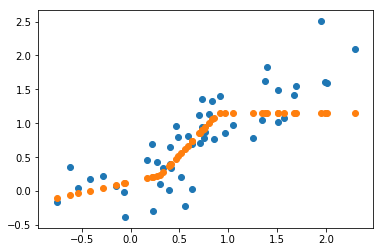

In [45]:
model = keras.Sequential()
#add a layer with 32 ReLU neurons
model.add(keras.layers.Dense(4,activation="relu",input_shape=(1,)))
#add a layer with 32 ReLU neurons
model.add(keras.layers.Dense(4,activation="relu"))
#NOTE: we don't need to specify input_shape for others than the first layer. Keras can deduce it automatically.
#add the output layer (1 neuron because only 1 predicted value)
model.add(keras.layers.Dense(1))
model.compile(optimizer=keras.optimizers.Adam(lr=0.01),loss="mean_squared_error")

#Define our training inputs and outputs. Our network takes in height (column 0 in the data) and outputs weight (column 1).
trainingInputs=scaled[:50,0]
trainingOutputs=scaled[:50,1]

#Reshape the tensors: This is needed because Tensorflow and Keras models expect to get data in batches, as specified above.
trainingInputs=np.reshape(trainingInputs,[trainingInputs.shape[0],1])
trainingOutputs=np.reshape(trainingOutputs,[trainingOutputs.shape[0],1])

#Fit the model. Epochs defines how many times the network will see all data during the training.
model.fit(trainingInputs,trainingOutputs,verbose=2,epochs=100)

#Scatterplot both the data and the predictions
pp.scatter(trainingInputs,trainingOutputs)
predictions=model.predict(trainingInputs)
pp.scatter(trainingInputs,predictions)